In [1]:
import wrangle

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from env import user, password, host
import env
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
zillow_train,zillow_validate,zillow_test=wrangle.wrangled_file()

In [3]:
zillow_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40900 entries, 39641 to 7566
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathroom                    40900 non-null  float64
 1   bedroom                     40900 non-null  float64
 2   calculatedbathnbr           40900 non-null  float64
 3   sqtft                       40900 non-null  float64
 4   finishedsquarefeet12        40900 non-null  float64
 5   fips                        40900 non-null  object 
 6   fullbathcnt                 40900 non-null  float64
 7   latitude                    40900 non-null  float64
 8   longitude                   40900 non-null  float64
 9   propertycountylandusecode   40900 non-null  object 
 10  rawcensustractandblock      40900 non-null  float64
 11  zipcode                     40900 non-null  object 
 12  roomcnt                     40900 non-null  float64
 13  yearbuilt                   

In [4]:
zillow_train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroom,40900.0,2.290795e+00,9.526837e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroom,40900.0,3.025526e+00,1.016471e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
calculatedbathnbr,40900.0,2.290795e+00,9.526837e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
sqtft,40900.0,1.765063e+03,9.412591e+02,2.420000e+02,1.176000e+03,1.526500e+03,2.075250e+03,2.192900e+04
finishedsquarefeet12,40900.0,1.765063e+03,9.412591e+02,2.420000e+02,1.176000e+03,1.526500e+03,2.075250e+03,2.192900e+04
fullbathcnt,40900.0,2.221980e+00,9.365509e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
latitude,40900.0,3.401251e+07,2.692061e+05,3.333953e+07,3.381467e+07,3.402853e+07,3.417910e+07,3.481877e+07
longitude,40900.0,-1.182042e+08,3.630728e+05,-1.194753e+08,-1.184233e+08,-1.181768e+08,-1.179250e+08,-1.175546e+08
rawcensustractandblock,40900.0,6.049261e+07,2.070572e+05,6.037101e+07,6.037400e+07,6.037621e+07,6.059042e+07,6.111009e+07
roomcnt,40900.0,1.534156e+00,2.868868e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01


In [7]:
def scale(scaler,zillow_train,cols=['bedroom','bathroom','sqtft','fullbathcnt',],return_scaler=True):
    zillow_train=zillow_train
    zillow_train_scaled=zillow_train.copy()
    scaler=scaler
    zillow_train_scaled[cols] = scaler.fit_transform(zillow_train[cols])
    return scaler, zillow_train_scaled

In [8]:
scaler,zillow_scaled=scale(MinMaxScaler(),zillow_train)

In [9]:
zillow_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40900 entries, 39641 to 7566
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathroom                    40900 non-null  float64
 1   bedroom                     40900 non-null  float64
 2   calculatedbathnbr           40900 non-null  float64
 3   sqtft                       40900 non-null  float64
 4   finishedsquarefeet12        40900 non-null  float64
 5   fips                        40900 non-null  object 
 6   fullbathcnt                 40900 non-null  float64
 7   latitude                    40900 non-null  float64
 8   longitude                   40900 non-null  float64
 9   propertycountylandusecode   40900 non-null  object 
 10  rawcensustractandblock      40900 non-null  float64
 11  zipcode                     40900 non-null  object 
 12  roomcnt                     40900 non-null  float64
 13  yearbuilt                   

In [10]:
zillow_scaled.describe()

,bathroom,bedroom,calculatedbathnbr,sqtft,finishedsquarefeet12,fullbathcnt,latitude,longitude,rawcensustractandblock,roomcnt,...,structuretaxvaluedollarcnt,taxvalue,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,taxrate,month,age
count,40900.000000,40900.000000,40900.000000,40900.000000,40900.000000,40900.000000,4.090000e+04,4.090000e+04,4.090000e+04,40900.000000,...,4.090000e+04,4.090000e+04,40900.0,4.090000e+04,40900.000000,4.090000e+04,40900.000000,40900.000000,40900.000000,40900.000000
mean,0.075929,0.216109,2.290795,0.070229,1765.062518,0.071881,3.401251e+07,-1.182042e+08,6.049261e+07,1.534156,...,1.904469e+05,4.912138e+05,2016.0,3.007668e+05,5996.708300,6.050299e+13,0.015682,0.013118,5.072934,52.355330
std,0.056040,0.072605,0.952684,0.043402,941.259103,0.055091,2.692061e+05,3.630728e+05,2.070572e+05,2.868868,...,2.294997e+05,6.758616e+05,0.0,5.141551e+05,7884.388826,2.099548e+12,0.161532,0.005019,2.349702,23.100631
min,0.000000,0.000000,1.000000,0.000000,242.000000,0.000000,3.333953e+07,-1.194753e+08,6.037101e+07,0.000000,...,1.480000e+02,1.168300e+04,2016.0,1.610000e+02,19.920000,6.037101e+13,-4.655420,0.000094,1.000000,6.000000
25%,0.058824,0.142857,2.000000,0.043067,1176.000000,0.058824,3.381467e+07,-1.184233e+08,6.037400e+07,0.000000,...,8.463725e+04,2.055908e+05,2016.0,8.340950e+04,2699.315000,6.037400e+13,-0.023866,0.011635,3.000000,35.000000
50%,0.058824,0.214286,2.000000,0.059229,1526.500000,0.058824,3.402853e+07,-1.181768e+08,6.037621e+07,0.000000,...,1.365025e+05,3.577980e+05,2016.0,2.019090e+05,4419.235000,6.037621e+13,0.006333,0.012265,5.000000,51.000000
75%,0.117647,0.285714,3.000000,0.084532,2075.250000,0.117647,3.417910e+07,-1.179250e+08,6.059042e+07,0.000000,...,2.192478e+05,5.667512e+05,2016.0,3.644675e+05,6884.090000,6.059042e+13,0.037694,0.013412,7.000000,68.000000
max,1.000000,1.000000,18.000000,1.000000,21929.000000,1.000000,3.481877e+07,-1.175546e+08,6.111009e+07,15.000000,...,7.824604e+06,4.906124e+07,2016.0,4.895220e+07,586639.300000,4.830301e+14,3.394544,0.493647,9.000000,144.000000


## Question 1
- Whether there has relationship between LogError and Age

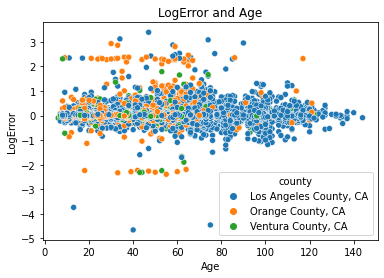

In [11]:
# plot age by logerror
sns.scatterplot(x=zillow_train.age, y=zillow_train.logerror,hue=zillow_train.county)
plt.xlabel("Age")
plt.ylabel("LogError")
plt.title("LogError and Age")
plt.show()

## Key Takeaway
- The age and log error don't seem to have any significant relationship in county when they pass age 80.
- Majority of them within 60 years built has significant log error with orange county
- The next step exploration would be whether there are signicant relationship with the taxrate and logerror

## Question 2
- Whether there has relationship between taxrate and logerror 

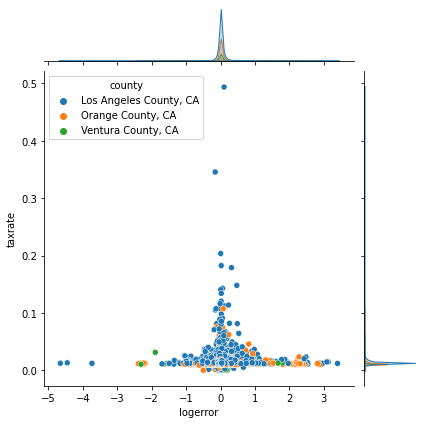

In [12]:
sns.jointplot(y="taxrate", x="logerror", data=zillow_train, hue = 'county')
plt.xlabel("county")
plt.ylabel("Logerror")
plt.show()

## Key Takeaway
- The logerror has showing significant with orange county, which is like what happened to the age
- The next step would be focusing on orange county to explore further for the reason of logerror

In [13]:
alpha = .05

In [14]:
zillow_train.county.value_counts()

Los Angeles County, CA    26607
Orange County, CA         10942
Ventura County, CA         3351
Name: county, dtype: int64

In [15]:
import scipy.stats as stats
orange = zillow_train[zillow_train.county== 'Orange County, CA'].logerror
other = zillow_train[zillow_train.county!='Orange County, CA'].logerror
orange.var(), other.var()

(0.03473064585770023, 0.022918095340899433)

In [16]:
t, p = stats.ttest_ind(orange, other, equal_var=False)
print(t, p/2, alpha)

4.394877524380426 5.5763512045746256e-06 0.05


In [17]:
if p/2 > alpha:
    print("We fail to reject H0")
elif t < 0:
    print("We fail to reject H0")
else:
    print("We reject H0 ")

We reject H0 


## Key Takeaway
- The orange county has significant different on the logerror compare to the other counties
- The orange county has 59.9% variable higher than other countiers 

## Question 4
- Is there a significant different between logerror and the bathroom and bedroom counts 

Is there a relationship
between room count and logerror?


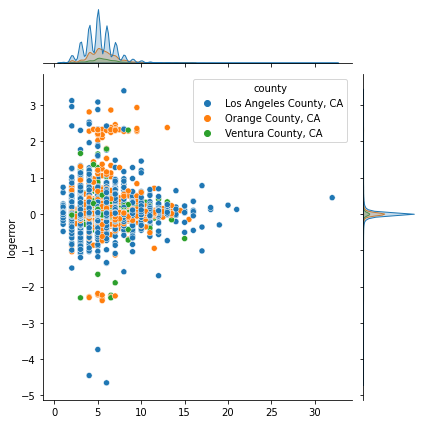

In [18]:
#creating a joinplot to see if any linear relationship
print("Is there a relationship\nbetween room count and logerror?")
room=zillow_train['bathroom']+zillow_train['bedroom']
sns.jointplot(x=room, y='logerror', data=zillow_train, hue = 'county')
plt.xlabel("Room")
plt.ylabel("Logerror")
plt.show()

In [19]:
zillow_train[zillow_train.logerror>=1.5].county.value_counts()

Orange County, CA         38
Los Angeles County, CA    22
Ventura County, CA         4
Name: county, dtype: int64

## Key Takeaway
- The orange county has significant higher logerror
- The orange county has higher logerror with room count between 3-8
- The logerror plays significant role on logerror
- Would recommend doing the prediction seperately with orange county to be one and rest of the county to be the other one

## Question 5
- Can we achieve lower logerror when seperate orange county out of overall 

<AxesSubplot:xlabel='county'>

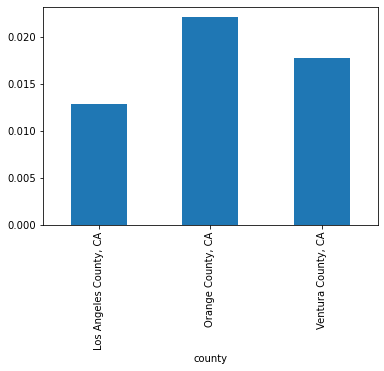

In [20]:
zillow_train.groupby('county').logerror.mean().plot.bar()

In [21]:
zillow_train['county1']=zillow_train['county'].replace(['Los Angeles County, CA', 'Ventura County, CA'], 'Other')

In [22]:
sns.scatterplot(x=nroom, y='logerror', data=zillow_train, hue='county1')
plt.xlabel("Room")
plt.ylabel("Logerror")
plt.show()

NameError: name 'nroom' is not defined

In [23]:
zillow_train.logerror.mean()-zillow_train[zillow_train.county1=='Other'].logerror.mean()

0.0023335510256327994

## Key Takeaway
- If we remove the orange county, the logerror doesn't have significant change
- The modeling would not remove the orange county